# Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import seaborn as sns
import statistics
import numpy
from sklearn.impute import SimpleImputer
from statsmodels.api import OLS, add_constant
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, recall_score, precision_score

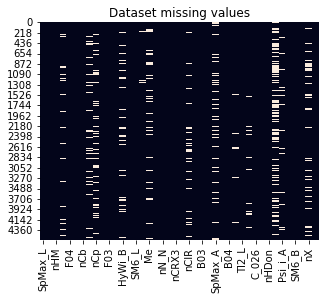

In [2]:
df = pd.read_csv("biodegradable_a.csv")
heatmap = df.isnull()
for col in df.columns:
    heatmap[col] = heatmap[col].apply(lambda x: 0 if x is False else 1)
plt.figure(figsize=(5,4))
sns.heatmap(heatmap, cbar=False).set_title('Dataset missing values')
plt.show()

In [3]:
X = df.loc[:, ~df.columns.isin(['Biodegradable'])]
y = df['Biodegradable']
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

# Selecting crucial variables

In [32]:
X_tr = add_constant(X)
mdl=OLS(y, X_tr, missing='drop',hasconst=12).fit()
for i, v in mdl.pvalues.items():
    print(i + ": " + str(v), end = ", ")

const: 2.0489668819355942e-14, SpMax_L: 8.557952282038236e-12, J_Dz(e): 0.6787066861892457, nHM: 1.7202463688704648e-14, F04: 0.6134417118488699, NssssC: 0.010438369251741826, nCb: 3.3047550238394547e-06, nCp: 2.794141767638892e-20, nO: 0.79995567564978, F03: 0.8146446067314944, SdssC: 4.705446507980274e-05, LOC: 7.668228171423537e-11, SM6_L: 2.1521482920875116e-05, Me: 0.009514843812296732, Mi: 2.346992042487664e-09, nN_N: 1.3935908318981917e-05, nArNO2: 7.0663329506364815e-25, nCRX3: 0.4128324668497465, SpPosA_B: 6.94937144779596e-05, B01: 0.07296310034507611, B03: 1.4382776222141322e-19, N_073: 0.9857674624793974, Psi_i_1d: 0.633773298764235, B04: 0.9341702252225936, SdO: 7.37543587971645e-05, TI2_L: 1.5371997776337212e-05, C_026: 0.0076895407523891275, F02_CN: 4.7003033194804305e-08, nHDon: 0.7987148265709498, Psi_i_A: 2.31555936137966e-09, nN: 2.3190983101273033e-11, SM6_B: 0.0003876994285921268, nArCOOR: 7.817552540160382e-07, 

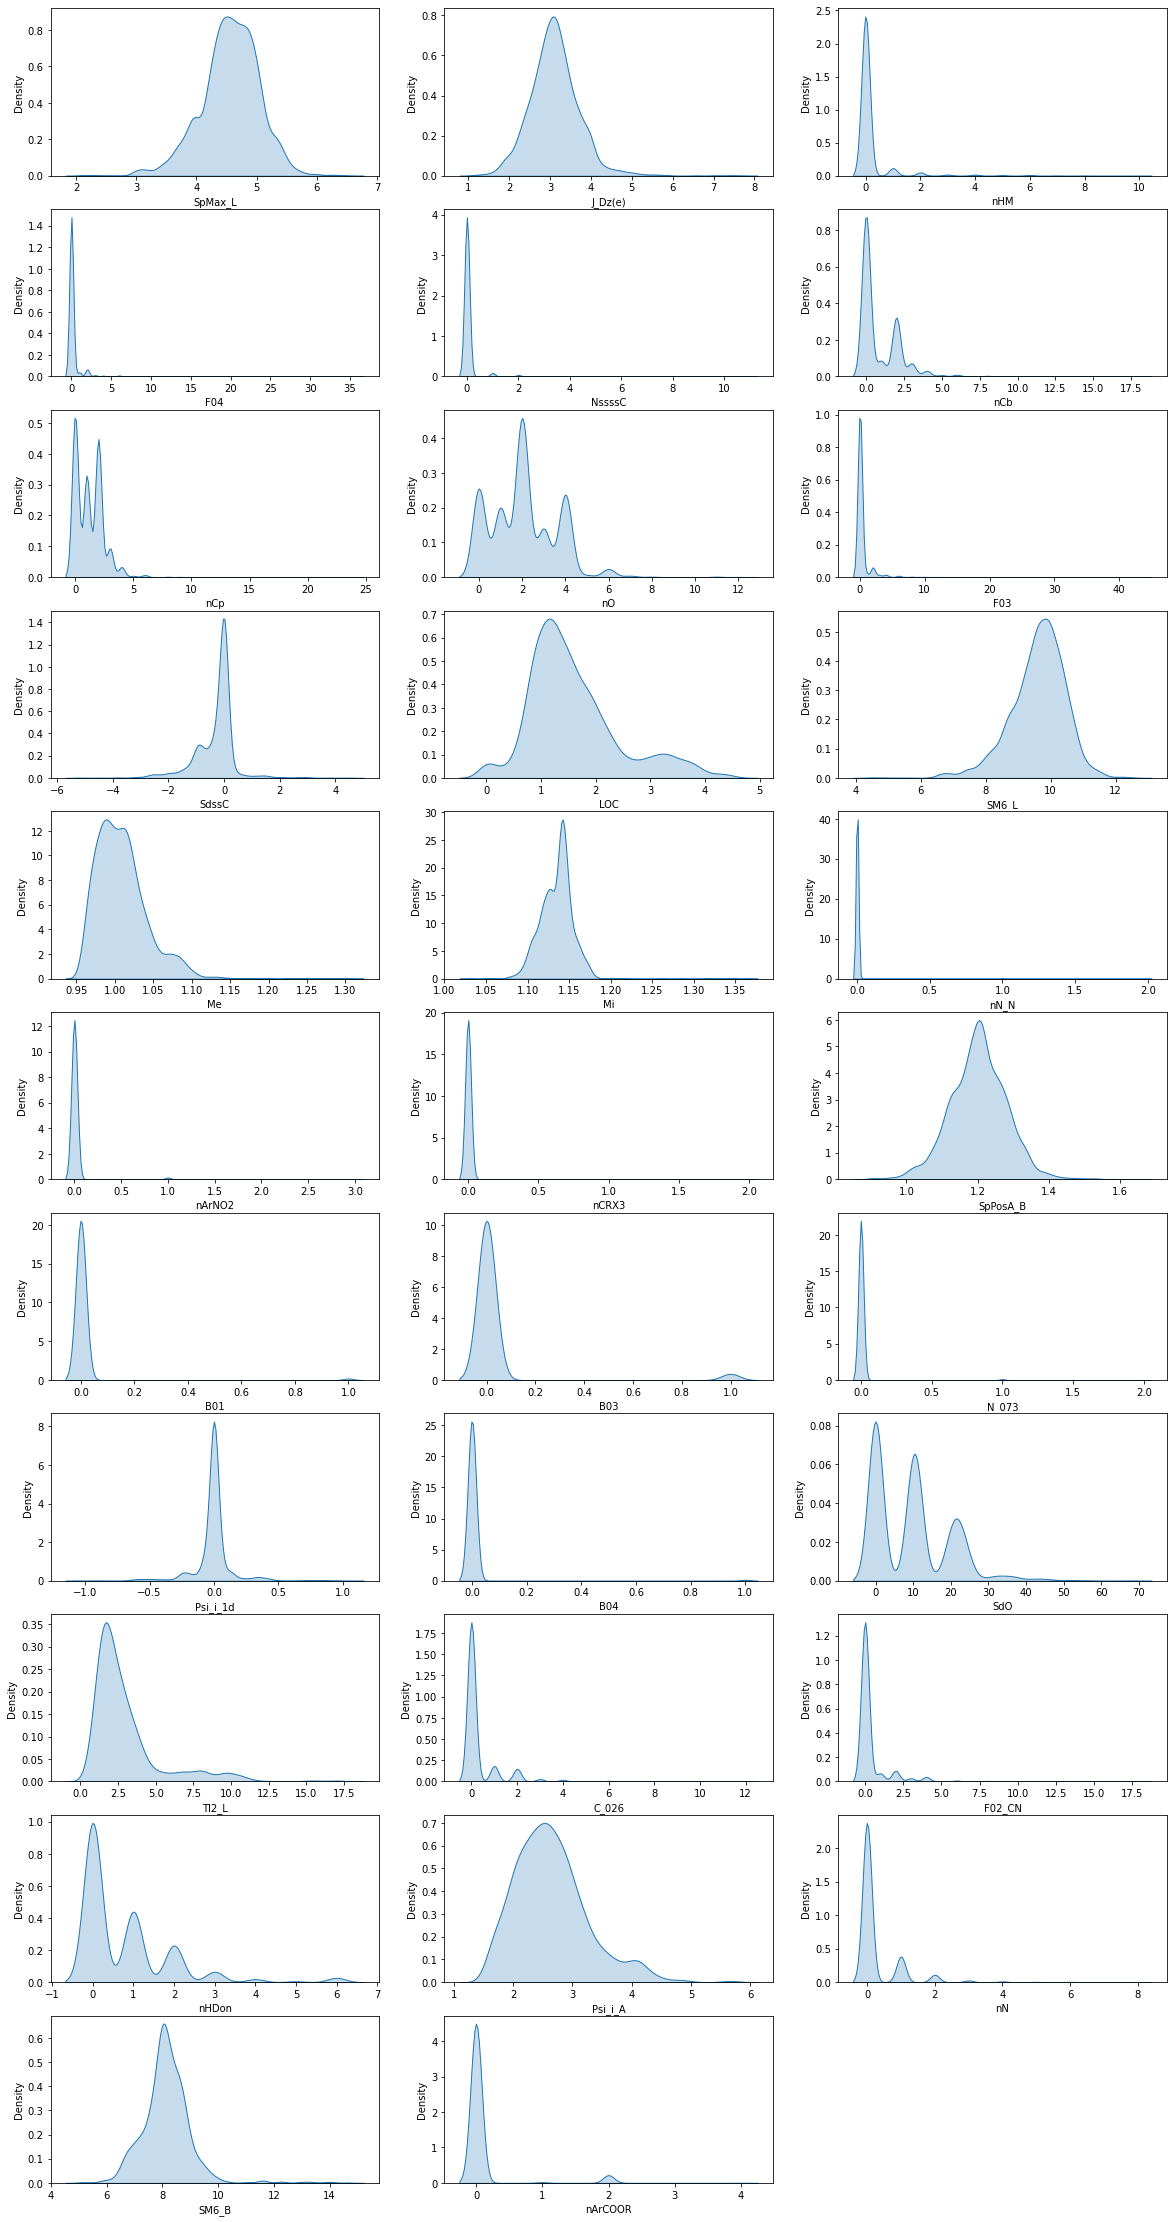

In [5]:
X = df.loc[:, ~df.columns.isin(['F01', 'C', 'HyWi_B', 'F03_CO', 'nCIR', 'SpMax_A', 'nCrt', 'SpMax_B', 'nX', 'Biodegradable'])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)
plt.figure(figsize=(20,40))
for i, col in enumerate(X_train.columns):
    plt.subplot(11,3,i + 1)
    sns.kdeplot(X_train[col] , fill=True)
    
plt.show()

# Objective

In [6]:
ss = preprocessing.StandardScaler()
pt = preprocessing.PowerTransformer()

toRemove = []

for col in X_train.columns:
    values, indices, counts = numpy.unique(X_train[col], return_index=True, return_counts=True)
    p = max(counts)/float(sum(counts))
    scale = max(X_train[col]) - min(X_train[col])
    threshold = scale/100.0
    if (statistics.variance(X_train[col].to_numpy()[~numpy.isnan(X_train[col])]) < threshold and p > 0.80):
        toRemove.append(col)

print(toRemove)
X_test = X_test.loc[:, ~X_test.columns.isin(toRemove)]
X_train = X_train.loc[:, ~X_train.columns.isin(toRemove)]

['nN_N', 'nArNO2', 'nCRX3', 'B01', 'N_073', 'B04']


In [ ]:
def scale_dataset(dataset):
    X_pt = dataset 
    X_ss = dataset

    plt.figure(figsize=(20,40))
    toPowerTransf = []
    for i in [3,4,5,6,7,8,9,13,18,19,20,21,22,24,26]:
        toPowerTransf.append(dataset.columns.values[i-1])
    print(toPowerTransf)

    X_pt = pd.DataFrame(pt.fit_transform(dataset.loc[:, dataset.columns.isin(toPowerTransf)]), columns=dataset.loc[:, dataset.columns.isin(toPowerTransf)].columns)

    X_ss = pd.DataFrame(ss.fit_transform(dataset.loc[:, ~dataset.columns.isin(toPowerTransf)]), columns=dataset.loc[:, ~dataset.columns.isin(toPowerTransf)].columns)

    X_scaled = pd.concat([X_pt, X_ss], axis=1)
    return X_scaled

X_train = scale_dataset(X_train)

X_test = scale_dataset(X_test)

for i, col in enumerate(X_train.columns):
    plt.subplot(10,3,i + 1)
    sns.kdeplot(X_train[col] , fill=True)
plt.show()

In [8]:
imp = SimpleImputer(missing_values=numpy.nan, strategy='median')
X_train = pd.DataFrame(data = imp.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data = imp.fit_transform(X_test), columns=X_test.columns)

In [9]:
class Classification:
    
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
    def random_forest(self, n_estimators = 100, max_depth = None, min_sample_split = 2):
        
        rfc = RandomForestClassifier(n_estimators = n_estimators, random_state = 0, max_depth = max_depth, 
                                     min_samples_split = min_sample_split)
        rfc.fit(self.X_train, self.y_train)

        rf_preds = rfc.predict(self.X_test)
        
        return rf_preds
        
    def decision_tree(self, max_depth = None, min_samples_split = 2):
        
        dtc = DecisionTreeClassifier(max_depth = max_depth, random_state = 0, min_samples_split = min_samples_split)
        dtc.fit(self.X_train, self.y_train)
        dt_preds = dtc.predict(self.X_test)
        
        return dt_preds
    
    def gaussian_naive_bayes(self):
        
        gnb=GaussianNB()
        gnb.fit(self.X_train, self.y_train)
        gnb_preds = gnb.predict(self.X_test)
        
        return gnb_preds

    def knn(self, n_neighbors = 5, weights = 'uniform'):

        knnC = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights)
        knnC.fit(self.X_train, self.y_train)
        knnC_preds = knnC.predict(self.X_test)
        
        return knnC_preds
    
    def supportVectorClassifier(self, C = 10, gamma = "auto", test_with_train=False):
    
        svc = SVC(kernel='rbf', C = C, gamma = gamma).fit(self.X_train, self.y_train)
        if (test_with_train == True): 
            svc_preds = svc.predict(self.X_train)
        else:
            svc_preds = svc.predict(self.X_test)

        return svc_preds
        
    def classification_score(self, y_test, preds):
        
        return accuracy_score(y_test, preds)

    def classification_score_print(self, y_test, preds):
        
        print("Accuracy: %7.4f" % accuracy_score(y_test, preds))
        print(f"Confusion matrix:\n{pd.DataFrame(confusion_matrix(y_test, preds))}")
        print("F1: %7.4f" % f1_score(y_test, preds))
        print("Recall: %7.4f" % recall_score(y_test, preds))
        print("Precision: %7.4f" % precision_score(y_test, preds))

In [11]:
rfr=RandomForestClassifier(random_state=0)
sel = SelectFromModel(estimator=rfr)
sel.fit(X_train, y_train)

print("Importances: ", sel.estimator_.feature_importances_)

print("Default threshold: ", sel.threshold_)
_, M =  X_train.shape
features = sel.get_support()
features_selected = numpy.arange(M)[features]
columnsSelected = []
columns = X_train.columns.tolist()
for i in features_selected:
    columnsSelected.append(columns[i])
c = Classification(X_train.loc[:,X_train.columns.isin(columnsSelected)], X_test.loc[:,X_test.columns.isin(columnsSelected)], y_train, y_test)
rf_preds = c.knn()
c.classification_score_print(y_test, rf_preds)

Importances:  [0.11351022 0.05975607 0.05403851 0.06667214 0.01676474 0.01696365
 0.06278163 0.02199918 0.02073633 0.02232198 0.02064524 0.06483761
 0.0070659  0.01779455 0.00092951 0.07742471 0.02942995 0.02842818
 0.02936202 0.03532796 0.03122776 0.05838419 0.02565134 0.01906966
 0.03167209 0.06720485]
Default threshold:  0.038461538461538464
Accuracy:  0.9465
Confusion matrix:
     0    1
0  146   40
1   21  934
F1:  0.9684
Recall:  0.9780
Precision:  0.9589


In [12]:
bestColumn = ""
bestValue = 0.0
columns = X_train.columns.to_list()
currentColumns = X_train.columns.to_list()
foundBetter = True
accuracy_scores = []
while(foundBetter == True):
    foundBetter = False
    for col in columns:
        tempColumns = currentColumns.copy()
        tempColumns.remove(col)
        c = Classification(X_train.loc[:,X_train.columns.isin(tempColumns)], X_test.loc[:,X_test.columns.isin(tempColumns)], y_train, y_test)
        rf_preds = c.gaussian_naive_bayes()
        acc = c.classification_score(y_test, rf_preds)
        if acc >= bestValue:
            bestColumn = col
            foundBetter = True
            bestValue = acc
        accuracy_scores.append(acc)
    if(foundBetter == True):
        columns.remove(bestColumn)
        currentColumns.remove(bestColumn)
print(len(currentColumns))
c = Classification(X_train.loc[:,X_train.columns.isin(currentColumns)], X_test.loc[:,X_test.columns.isin(currentColumns)], y_train, y_test)
rf_preds = c.knn()
c.classification_score_print(y_test, rf_preds)

17
Accuracy:  0.9579
Confusion matrix:
     0    1
0  146   40
1    8  947
F1:  0.9753
Recall:  0.9916
Precision:  0.9595


Best max depth: 4
Accuracy:  0.9238
Confusion matrix:
     0    1
0  142   44
1   43  912
F1:  0.9545
Recall:  0.9550
Precision:  0.9540


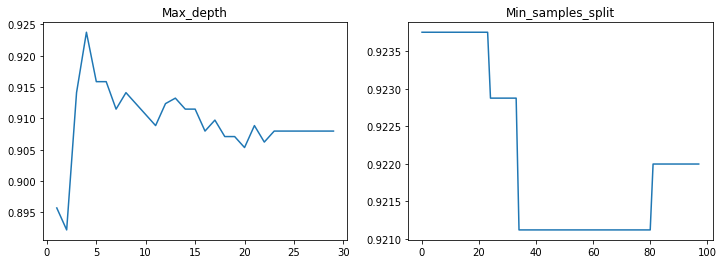

Best min samples split: 2
Accuracy:  0.9238
Confusion matrix:
     0    1
0  142   44
1   43  912
F1:  0.9545
Recall:  0.9550
Precision:  0.9540


In [13]:
X_train = X_train.loc[:,X_train.columns.isin(columnsSelected)]
X_test = X_test.loc[:,X_test.columns.isin(columnsSelected)]

acc_scores = []
bestValue = 0.0
bestMD = 0
for i in range(1,30):
    c = Classification(X_train, X_test, y_train, y_test)
    rf_preds = c.decision_tree(max_depth=i)
    acc = c.classification_score(y_test, rf_preds) 
    acc_scores.append(acc)
    if acc > bestValue:
        bestMD = i
        bestValue = acc

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,len(acc_scores)+1,1), acc_scores)
plt.title("Max_depth")

print(f"Best max depth: {bestMD}")
c = Classification(X_train, X_test, y_train, y_test)
rf_preds = c.decision_tree(max_depth=bestMD)
c.classification_score_print(y_test, rf_preds) 

bestValue = 0.0
acc_scores = []

bestMSS = 0
for i in range(2,100):
    c = Classification(X_train, X_test, y_train, y_test)
    rf_preds = c.decision_tree(min_samples_split=i, max_depth=bestMD)
    acc = c.classification_score(y_test, rf_preds)
    acc_scores.append(acc)
    if acc > bestValue:
        bestMSS = i
        bestValue = acc

plt.subplot(1,2,2)
plt.plot(range(len(acc_scores)), acc_scores)
plt.title("Min_samples_split")
plt.show()
print(f"Best min samples split: {bestMSS}")
c = Classification(X_train, X_test, y_train, y_test)
rf_preds = c.decision_tree(min_samples_split=bestMSS, max_depth=bestMD)
c.classification_score_print(y_test, rf_preds) 

# Gaussian NB

In [14]:
rf_preds = c.gaussian_naive_bayes()
c.classification_score_print(y_test, rf_preds)

Accuracy:  0.9150
Confusion matrix:
     0    1
0  150   36
1   61  894
F1:  0.9485
Recall:  0.9361
Precision:  0.9613


# Random Forest

Best max depth: 23
Accuracy:  0.9334
Confusion matrix:
     0    1
0  162   24
1   52  903
F1:  0.9596
Recall:  0.9455
Precision:  0.9741
Best number of estimators: 100
Accuracy:  0.9334
Confusion matrix:
     0    1
0  162   24
1   52  903
F1:  0.9596
Recall:  0.9455
Precision:  0.9741


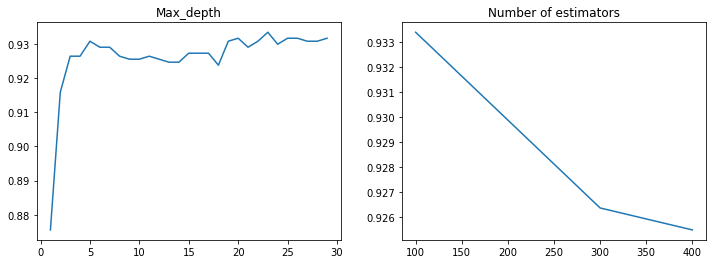

In [33]:
acc_scores = []
bestValue = 0.0
bestMD = 0
bestEstm = 0
for i in range(1,30):
    c = Classification(X_train, X_test, y_train, y_test)
    rf_preds = c.random_forest(max_depth=i)
    acc = c.classification_score(y_test, rf_preds) 
    acc_scores.append(acc)
    if acc > bestValue:
        bestMD = i
        bestValue = acc

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,len(acc_scores)+1,1), acc_scores)
plt.title("Max_depth")
print(f"Best max depth: {bestMD}")
c = Classification(X_train, X_test, y_train, y_test)
rf_preds = c.random_forest(max_depth=bestMD)
c.classification_score_print(y_test, rf_preds) 

bestValue = 0.0
acc_scores = []
for i in range(100, 500, 100):
    c = Classification(X_train, X_test, y_train, y_test)
    rf_preds = c.random_forest(n_estimators=i, max_depth=bestMD)
    acc = c.classification_score(y_test, rf_preds) 
    acc_scores.append(acc)
    if acc > bestValue:
        bestEstm = i
        bestValue = acc

plt.subplot(1,2,2)
plt.plot(range(100, 500, 100), acc_scores)
plt.title("Number of estimators")
print(f"Best number of estimators: {bestEstm}")
c = Classification(X_train, X_test, y_train, y_test)
rf_preds = c.random_forest(n_estimators=bestEstm, max_depth=bestMD)
c.classification_score_print(y_test, rf_preds) 

# SVC

bestC: 0.1
BestGamma: 0.1
Accuracy:  0.9273
Confusion matrix:
     0    1
0  139   47
1   36  919
F1:  0.9568
Recall:  0.9623
Precision:  0.9513


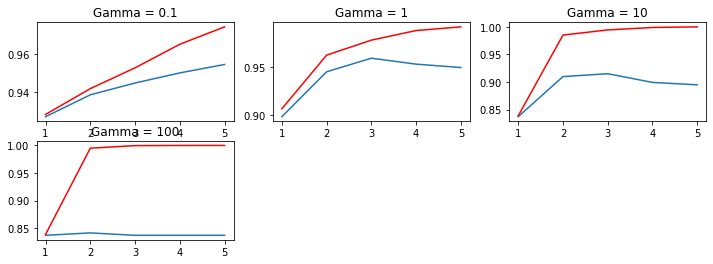

In [16]:
acc_scores = []
bestValue = 1
bestC = 0
bestGamma = 0
acc_tr = []
cs = [0.1, 1, 10, 100, 1000]
g = [0.1, 1, 10, 100]
plt.figure(figsize=(12,4))
for i, e in enumerate(g):
    plt.subplot(2,3,i + 1)
    plt.title("Gamma = " + str(e)) 
    for j in cs:
        c = Classification(X_train, X_test, y_train, y_test)
        rf_preds = c.supportVectorClassifier(gamma=e, C= j)
        rf_preds_train = c.supportVectorClassifier(gamma=e, C = j, test_with_train=True)
        acc = c.classification_score(y_test, rf_preds) 
        acc_t = c.classification_score(y_train, rf_preds_train)
        acc_tr.append(acc_t)
        acc_scores.append(acc)
        if acc_t - acc < bestValue:
            bestC = j
            bestGamma = e
            bestValue = acc_t - acc
    plt.plot(range(1,len(acc_scores)+1,1), acc_scores)
    plt.plot(range(1,len(acc_scores)+1,1), acc_tr, 'r')
    acc_scores = []
    acc_tr = []

print("bestC: " + str(bestC) + "\nBestGamma: " + str(bestGamma))
c = Classification(X_train, X_test, y_train, y_test)
rf_preds = c.supportVectorClassifier(C=bestC, gamma=bestGamma)           
c.classification_score_print(y_test, rf_preds)


# KNN

bestNNeighbors: 7
bestWeight: distance
Accuracy:  0.9509
Confusion matrix:
     0    1
0  149   37
1   19  936
F1:  0.9710
Recall:  0.9801
Precision:  0.9620


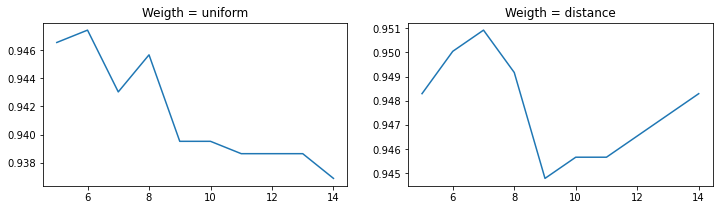

In [17]:
acc_scores = []
bestValue = 0
bestNNeighbors = 0
bestWeight = ''
acc_tr = []
weigths = ['uniform', 'distance']
plt.figure(figsize=(12,3))
for i, e in enumerate(weigths):
    plt.subplot(1,2,i + 1)
    plt.title("Weigth = " + str(e)) 
    for j in range(5,15):
        c = Classification(X_train, X_test, y_train, y_test)
        rf_preds = c.knn(n_neighbors=j, weights = e)
        acc = c.classification_score(y_test, rf_preds) 
        acc_scores.append(acc)
        if acc > bestValue:
            bestNNeighbors = j
            bestWeight = e
            bestValue = acc
    plt.plot(range(5,15), acc_scores)
    acc_scores = []
    acc_tr = []

print("bestNNeighbors: " + str(bestNNeighbors) + "\nbestWeight: " + str(bestWeight))
c = Classification(X_train, X_test, y_train, y_test)
rf_preds = c.knn(n_neighbors=bestNNeighbors, weights = bestWeight)           
c.classification_score_print(y_test, rf_preds)